The goal for this notebook is a streamlined, reproducable method of calculating the drift rates of all eligible planets in the NASA Exoplanet Database. 

There are 7 parameters necessary to calculate a planet's orbital drift rate: orbital period, semimajor axis, stellar mass, eccentricity, argument of periastron, inclination, and longitude of ascending node. As not all exoplanets have a measured value for each of these parameters, this notebook will provide methods to mitigate these insecurities.

In [1]:
#general utility packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import csv
from scipy.stats import beta

#nice modules from astropy
import astropy.units as u
import astropy.constants as const

#cool package that makes good ellipses
!pip install PyAstronomy
import PyAstronomy
from PyAstronomy import pyasl

#frequently used constants
pi = np.pi
G_units = const.G
G = 6.67 * 10 **(-11)
c_units = const.c
c = 3 * 10**8

## Data from the NASA Exoplanet Archive

The data I will be using for this project comes from the [NASA Exoplanet Archive (NEA)](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1) which produces a nice spreadsheet. The column names I will be frequently using are:

Stellar Mass (Solar Masses) = st_mass

Stellar Radius = st_rad

Planet Name = pl_name

Planet Radius = pl_rade

Planet Density (g/cm^3) = pl_dens

Planet Mass (Earth Masses) = pl_masse

Planet Temerature (K) = pl_eqt

Semimajor Axis = pl_orbsmax

Period in Days = pl_orbper

Eccentricity = pl_orbeccen

Inclination = pl_orbincl

Argument of Periapse = pl_orblper

Stellar Effective Temperature (K) = st_teff

Discovery Method = discoverymethod

Discovery Facility = disc_facility

In [3]:
#Downloaded csv from NEA, currently at 4438 confirmed planets (7/27/21)
df_all = pd.read_csv('/Users/megan/orbital_parameters_all.csv')
#Available on Github as orbital_parameters_all.csv

## Applying Kepler's Third Law

Kepler's Third Law relates 3 of our necessary parameters to each other: stellar mass, semimajor axis, and orbital period. Thus, calculations can be run on any planet with 2/3 of these parameters measured to get the third one. In this step, that is what I will do. 

Planets that only have 1 out of these 3 cannot be used in this project. All three of these parameters are not presumed to be nicely distributed across some bound numbers (like other parameters are,) so I have no current methods of simulating these values. As of 8/3/21, this is only 30 planets out of 4455 planets, so I am counting this as a negligible loss to our sample. This section of the code also saves the planets that are not eligible to a text file.

In [4]:
def keplers_third_law(df):
    trashed_planets = []
    df_solved = df
    for index, row in df_solved.iterrows():
        if pd.isna(row['pl_orbsmax']) == False and pd.isna(row['pl_orbper']) == False and pd.isna(row['st_mass']) == False:
        #All 3 values have numbers, don't need to be solved or dropped
            pass
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == True:
            #2/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['st_mass']) == True:
            #2/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbper']) == True and pd.isna(row['st_mass']) == True:
            #2/3 missing, drop row  
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == True and pd.isna(row['st_mass']) == True:
            #3/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == False and pd.isna(row['st_mass']) == False:
            #only semimajor axis is missing
            df.loc[index, 'pl_orbsmax'] = (row['st_mass'] * (row['pl_orbper']/365)**2) **(1/3)
            #Kepler's Third Law solved for semimajor axis
        elif pd.isna(row['pl_orbper']) == True and pd.isna(row['pl_orbsmax']) == False and pd.isna(row['st_mass']) == False:
            df.loc[index, 'pl_orbper'] = (row['pl_orbsmax']**3/(row['st_mass']))**(1/2)
            #Kepler's Third Law solved for period
        else:
            df.loc[index, 'st_mass'] = row['pl_orbsmax']**3/(row['pl_orbper']/365)**2
            #Kepler's Third Law solved for stellar mass
    with open("trashed_planets.txt", "w") as file:
        file.write(str(trashed_planets))
        #saving the trashed planets to an external file
        print(len(trashed_planets))
    return df_solved

In [5]:
df_kepler_solved = keplers_third_law(df_all)
#Prints out the number of thrown out planets

30


## Randomly Assigned Values: Inclination, Argument of Periastron, and Longitude of Ascending Node

An orbit's inclination, argument of periastron, and longitude of ascending node essentially have no rhyme or reason to be distributed a certain way, so I will simulate missing values for these angles to be random across all possible values. That is, from 0 to 360 degrees for argument of periastron and longitude of ascending node, and from -90 to 90 degrees for inclination.

In [6]:
def assign_inclination(df):
    df_inc = df
    for index, row in df_inc.iterrows():
        random_inc = random.uniform(-90, 90)
        if pd.isna(row['pl_orbincl']) == True:
        #If the inclination is null    
            df.loc[index, 'pl_orbincl'] = random_inc
    return df_inc

In [7]:
df_kepler_inc = assign_inclination(df_kepler_solved)

In [8]:
def assign_arg_of_peri(df):
    df_aop = df
    for index, row in df_aop.iterrows():
        random_aop = random.uniform(0, 360)
        if pd.isna(row['pl_orblper']) == True:
        #If the argument of periastron is null    
            df.loc[index, 'pl_orblper'] = random_aop
    return df_aop

In [9]:
df_kepler_inc_aop = assign_arg_of_peri(df_kepler_inc)

In [10]:
#There are basically no measured longitudes of ascending node (only 4/~4500, so I'll just randomly assign all of them)
def assign_long_of_asc_node(df):
    df_loan = df
    loans = []
    for index in df_loan.iterrows():
        random_loan = random.uniform(0, 360)
        loans.append(random_loan)
    df_loan['long_of_asc_node'] = loans
    return df_loan

In [11]:
df_kepler_inc_aop_loan = assign_long_of_asc_node(df_kepler_inc_aop)

## Eccentricity : Beta Distribution

For unmeasured eccentricities, I will be pulling numbers from a beta distribution as described in [Kipping 2013](https://arxiv.org/abs/1306.4982).

In [12]:
def assign_ecc(df):
    df_ecc = df
    for index, row in df_ecc.iterrows():
        random_ecc = beta.rvs(0.867, 3.03)
        if pd.isna(row['pl_orbeccen']) == True:
        #If the eccentricity is null    
            df.loc[index, 'pl_orbeccen'] = random_ecc
    return df_ecc

In [13]:
df_all = assign_ecc(df_kepler_inc_aop_loan)
df_all.to_csv('all_orbital_parameters.csv')
#Our dataframe is complete, so I am saving it to a csv to avoid having multiple versions running around 
#as many of the values would change each time the code is run

## Calculating Drift Rates

### Drift Rates Function

The drift_rates function is the only computing function in the entire notebook. First, it builds an elliptical orbit based on the 7 orbital parameters and then samples this orbit num_timestep times. These samples return radial components, which are plugged into the gravitational accleration equation (GM/r^2) to get an acceleration at each of these points. Then, the function projects these acceleration vectors along the axis between the transmitter and the observer (Earth), and returns 200 scalar drift rates for each planet.

Parameters should be in units of au, years, and degrees: 

e is the eccentricity of the orbit


omega is longitude of ascending node in degrees


i is inclination in degrees


w is argument is periapse in degrees


num_timestep is the number of data points to build the ellipse, I've been using 200

In [14]:
def drift_rates(semimajor, period, e, omega, i, w, stellar_mass, num_timestep):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    radius = ke.radius(t)
    total_acc = G*stellar_mass*u.Msun/(radius* u.au)**2
    z_acceleration_array = []
    vector_to_earth = [0,0,1]
    for i in range(0, num_timestep):
        position_vector = ke.xyzPos(t)[i,:]
        radius = ke.radius(t)
        # vector from the origin (host star) to the point in the orbit
        z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
        # normalized magnitude of the vector in the observer's direction - between -1 and 1
        z_acceleration_array.append((z_magnitude * total_acc[i].si).value/c)
    return z_acceleration_array

The next cell saves the drift rates in 2 separate csvs. This is the cell that **takes the longest time, around 5+ hours,** so I try to run this the fewest times possible. It only needs to be run every time there's an update to the NEA.

#### 1st way: drift_rates_pl_name

This csv saves an individual column for each planet where the title of the column is the planet's name. I use this csv/dataframe to sort out the drift rates by specific criteria such as discovery method, discovery facility, etc.

#### 2nd way: drift_rates_column

This csv is just one really long column with all 80000 or so drift rates. This csv/column is for plotting all the planets the same way.

In [16]:
drift_rates_pl_name = pd.DataFrame()
cumulative_drift_rates_list = []
drift_rates_column = pd.DataFrame()
for index, row in pd.read_csv('all_orbital_parameters.csv').iterrows():
    drift_rates_list = drift_rates(row['pl_orbsmax'], row['pl_orbper']/365.25, row['pl_orbeccen'], row['long_of_asc_node'], row['pl_orbincl'], row['pl_orblper'], row['st_mass'], 200)
    drift_rates_pl_name[row['pl_name']] = drift_rates_list
    for drift_rate in drift_rates_list:
        cumulative_drift_rates_list.append(drift_rate)
drift_rates_pl_name.to_csv('drift_rates_pl_name.csv')
drift_rates_column['drift_rates'] = cumulative_drift_rates_list
drift_rates_column.to_csv('drift_rates_column.csv')
#Calculating all drift rates and then saving to a csv so I don't have to calculate them anymore

## Plotting Tools

To visualize my drift rates, I will plot a series of varying histograms highlighting various aspects of the data. In this section, I will describe some tools I will use to enhance the plots.

In [ ]:
df_all_parameters = pd.read_csv('all_orbital_parameters.csv')
#This is the same as df_all listed earlier, but read in at this step so that the random numbers aren't drawn again

The main takeaway from this project is to calculate what percentage of planets fall between +/-x nHz drift rates and vice versa (what drift rates contain x% of planets). The following function provides the means for doing so by returning the values that fall between certain percentage bounds (counted from the median value, which is likely 0).

In [18]:
def percentage_of_central_values(percent, list_):
    #This function will provide bounds on the histogram for an any percent of the values
    sorted_list = sorted(map(abs, list_))
    number_of_entries = round(len(list_) * percent/100)
    central_values = sorted_list[0:number_of_entries]
    return central_values

### Filling in Other (Non-Orbital) Parameters

The following functions calculate and fill in parameters that are fun to analyze and color-code, but not actually necessary to calculate drift rates.

In [20]:
def fill_in_radii(df):
    #This function will fill in as many radii as possible to plot the rocky vs not-rocky histogram
    df_radii = df
    for index, row in df_radii.iterrows():
        if pd.isna(row['pl_rade']) == False:
            pass
        elif pd.isna(row['pl_masse']) == False and pd.isna(row['pl_dens']) == False:
            #This formula is taken from Weiss and Marcy, 2014
            #Density of earth is 5.519 g/cm**3
            df_radii.loc[index, 'pl_rade'] = (5.519/row['pl_dens'] * row['pl_masse']) ** (1/3)
        else:
            df_radii.drop(index, inplace = True)
    return df_radii

In [21]:
filled_radius = fill_in_radii(df_all_parameters)

In [23]:
def fill_in_teq(df):
    #This function will fill in planet temperatures for a "habitable zone" histogram
    #Filling in 0.3 for albedo
    df_teq = df
    for index, row in df_teq.iterrows():
        if pd.isna(row['pl_eqt']) == False:
            pass
        elif pd.isna(row['pl_eqt']) == True and pd.isna(row['st_teff']) == True:
            df_teq.drop(index, inplace = True)
        else:
            df_teq.loc[index, 'pl_eqt'] = row['st_teff'] * (0.7)**0.25 * (row['st_rad'] /(2* row['pl_orbsmax']))**0.5
    return df_teq

In [24]:
filled_teq = fill_in_teq(df_all_parameters)

### Sorting Functions

The following functions sort the planets by specific criteria, creating dictionaries of planet names by category.

From the discovery method pie chart (also uploaded to Github), we found out that most of our planets are discovered via transit detection. To try to correct for these biases, it may be pertinent to know what kinds of drift rates transiting planets exhibit. The following function separates the planets by discovery method.

In [19]:
def sort_by_disc_method(df):
    #I will use this function to create separate the planets by discovery method into a dictionary
    methods = df['discoverymethod'].value_counts()[:8].index.tolist()
    method_planets = {}
    for method in methods:
        lst = []
        for index, row in df.iterrows():
            if row['discoverymethod'] == method:
                lst.append(row['pl_name'])
        method_planets.update({method: lst})
    w = csv.writer(open("method_planets.csv", "w"))
    for key, val in method_planets.items():
        w.writerow([key, val])
    return method_planets

In [22]:
def sort_by_radius(df):
    radius_categories = {}
    big_radii = []
    small_radii = []
    for index, row in df.iterrows():
        if row['pl_rade'] >= 1.6:
            big_radii.append(row['pl_name'])
        else:
            small_radii.append(row['pl_name'])
    radius_categories.update({'Possibly Rocky':small_radii})
    radius_categories.update({'Probably Not Rocky':big_radii})
    w = csv.writer(open("rocky_or_not.csv", "w"))
    for key, val in radius_categories.items():
        w.writerow([key, val])
    return radius_categories

In [25]:
def sort_by_teq(df):
    #This function will sort the planets into a "habitable zone", which I'm calling 273-373 K
    habitable_or_not = {}
    habitable = []
    no = []
    for index, row in df.iterrows():
        if row['pl_eqt'] >= 273 and row['pl_eqt'] <= 373:
            habitable.append(row['pl_name'])
        else:
            no.append(row['pl_name'])
    habitable_or_not.update({'Habitable': habitable})
    habitable_or_not.update({'Not Habitable': no})
    w = csv.writer(open("habitable_or_not.csv", "w"))
    for key, val in habitable_or_not.items():
        w.writerow([key, val])
    return habitable_or_not

### Categorizing the Drift Rates

The following function categorizes the drift rates according to the dictionaries in the last section. To clarify, the last section __only__categorizes__planet_names__ and doesn't actually touch the drift rates at all. That is done in this step. The nested lists are slightly clunky, but I believe them to be a good option for the stacked histograms.

In [26]:
def cat_drift_rates(dct, df):
    #This function will take categorized planets and return their drift rates in a nested list for plotting
    drift_rates = []
    for key in dct.keys():
        lst = []
        for val in dct[key]:
            for col in df:
                if col == val:
                    for row in df[col]:
                        lst.append(row)
        drift_rates.append(lst)
    return drift_rates

In [32]:
sorted_by_disc_method_dr = cat_drift_rates(sort_by_disc_method(df_all_parameters), drift_rates_pl_name)
#Nested list for plotting by discovery method

In [33]:
sorted_by_radius_df = cat_drift_rates(sort_by_radius(filled_radius), drift_rates_pl_name)
#Nested list for plotting by radius

In [44]:
sorted_by_teq_df = cat_drift_rates(sort_by_teq(filled_teq), drift_rates_pl_name)
#Nested list for plotting by equilibrium temperature

## Plots

In [29]:
all_drift_rates = pd.read_csv('drift_rates_column.csv')

These colors are chosen with colorblindness in mind from [here](https://gist.github.com/thriveth/8560036)

In [45]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

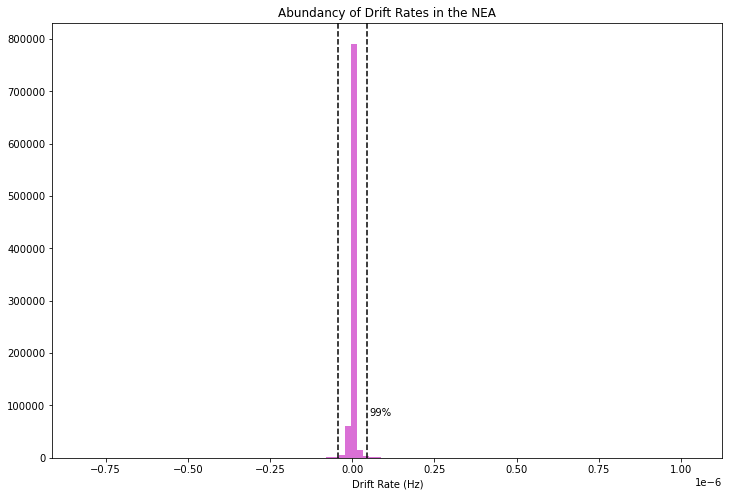

In [30]:
#Linearly Scaled Histogram with Central 50%
plt.figure(figsize = [12,8])
linear_markers = percentage_of_central_values(99, all_drift_rates['drift_rates'])
limit_linear = linear_markers[-1]
plt.hist(all_drift_rates['drift_rates'], color = 'orchid', bins = 100)
plt.axvline(x = limit_linear, color = 'k', linestyle = 'dashed')
plt.axvline(x = -limit_linear, color = 'k', linestyle = 'dashed')
plt.text(1.2*limit_linear, 8*10**4, '99%')
plt.xlabel('Drift Rate (Hz)')
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('linear_histogram.png')
plt.show()

4.362617140847653e-08


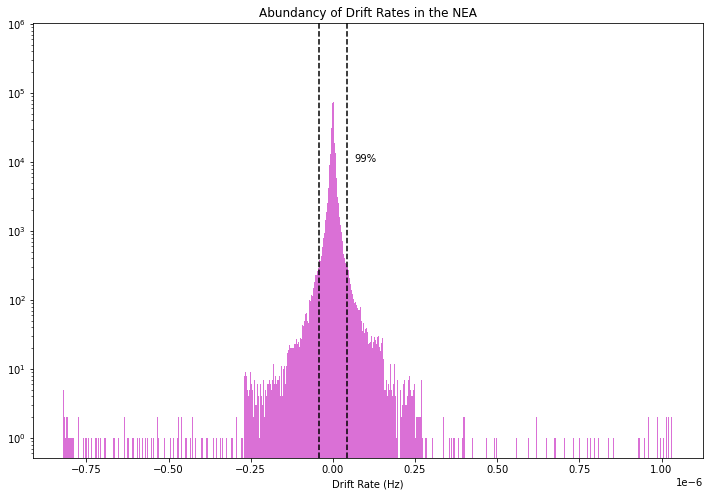

In [31]:
#Logarithmically Scaled Histogram with Central 99%
plt.figure(figsize = [12,8])
log_markers = percentage_of_central_values(99, all_drift_rates['drift_rates'])
limit_log = log_markers[-1]
print(limit_log)
plt.hist(all_drift_rates['drift_rates'], color = 'orchid', bins = 1000)
plt.axvline(x = limit_log, color = 'k', linestyle = 'dashed')
plt.axvline(x = -limit_log, color = 'k', linestyle = 'dashed')
plt.text(1.5*limit_log, 10**4, '99%')
plt.xlabel('Drift Rate (Hz)')
plt.yscale('log')
plt.savefig('log_histogram.png')
plt.title('Abundancy of Drift Rates in the NEA')
plt.show()

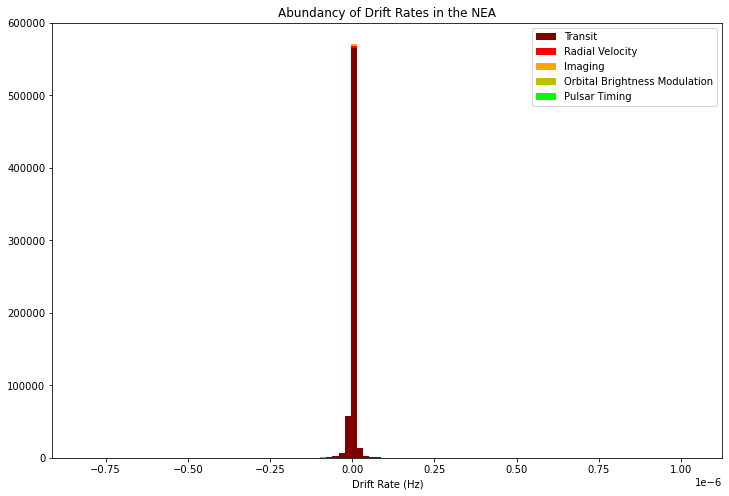

In [42]:
#Linearly Scaled Histogram by Discovery Method
plt.figure(figsize = [12,8])
labels = df['discoverymethod'].value_counts()[:8].index.tolist()
plt.hist(sorted_by_disc_method_dr, bins = 100, color = ['maroon', 'red','orange', 'y', 'lime'],  stacked = True)
plt.xlabel('Drift Rate (Hz)')
plt.yscale('linear')
plt.legend(labels)
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('linear_disc_method_histogram.png')
plt.show()

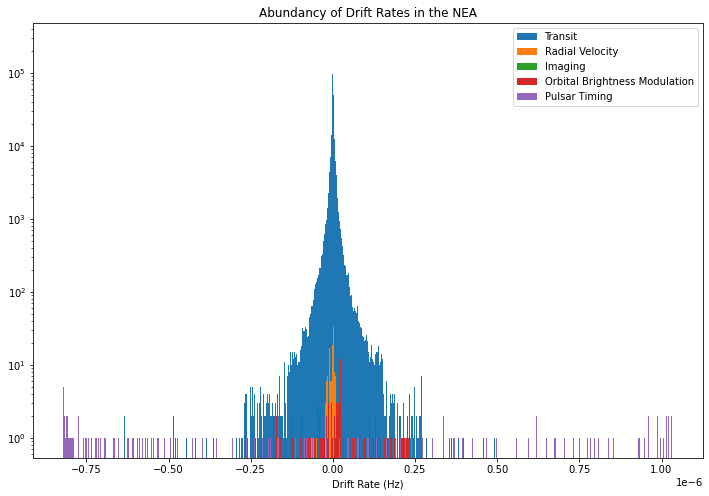

In [43]:
#Logarithmically Scaled Histogram by Discovery Method (Overlapped)
plt.figure(figsize = [12,8])
labels = df['discoverymethod'].value_counts()[:8].index.tolist()
for lst in sorted_by_disc_method_dr:
    plt.hist(lst, bins = 1000)
plt.xlabel('Drift Rate (Hz)')
plt.yscale('log')
plt.legend(labels)
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('log_overlap_disc_method_histogram.png')
plt.show()

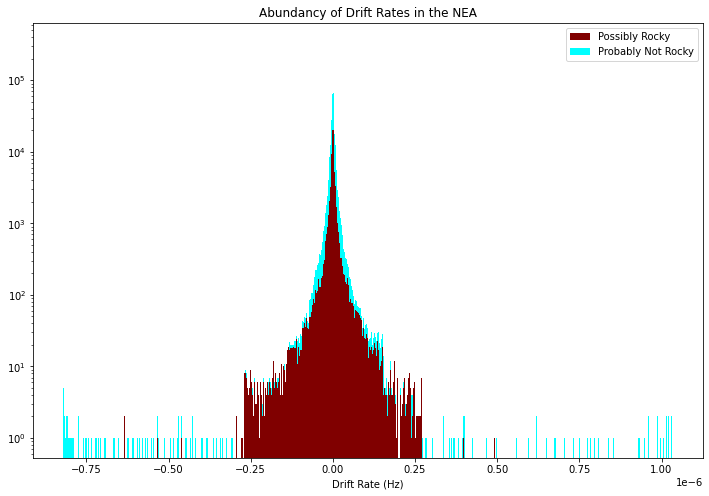

In [37]:
#Logarithmically scaled histogram by radii (are they rocky?)
plt.figure(figsize = [12,8])
labels = ['Possibly Rocky', 'Probably Not Rocky']
plt.hist(sorted_by_radius_df, bins = 1000, color = ['maroon','cyan'],  stacked = True)
plt.xlabel('Drift Rate (Hz)')
plt.yscale('log')
plt.legend(labels)
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('log_radius_histogram.png')
plt.show()

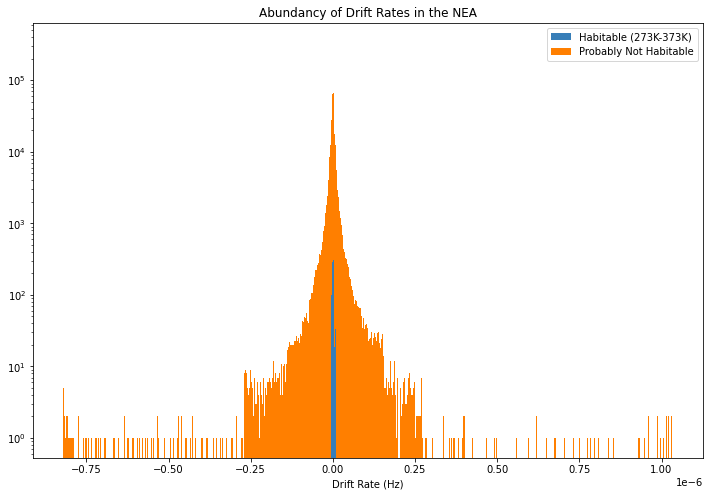

In [41]:
#Logarithmically scaled histogram by temperature (are they habitable?)
plt.figure(figsize = [12,8])
labels = ['Habitable (273K-373K)', 'Probably Not Habitable']
plt.hist(sorted_by_teq_df, bins = 1000, color = [CB_color_cycle[0],CB_color_cycle[1]],  stacked = True)
plt.xlabel('Drift Rate (Hz)')
plt.yscale('log')
plt.legend(labels)
plt.title('Abundancy of Drift Rates in the NEA')
plt.savefig('log_teq_histogram.png')
plt.show()